In [15]:
import pandas as pd

In [16]:
datafrm = pd.read_csv('ConoToxin_dataset.csv')

In [17]:
train_df = datafrm.iloc[:145,:]

In [19]:
test_df = datafrm.iloc[145:,:]

In [20]:
import torch
import esm

# Load ESM-2 model
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()  # disables dropout for deterministic results

/Users/arezoobybordi/miniforge3/envs/ninen/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
    (1): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bia

In [21]:
train_data = [(tuple(list(x))[1], tuple(list(x))[0])  for x in list(train_df[['SEQUENCE','ACC_ID']].values)]

In [22]:
dummy_train = train_data

In [23]:
tr_batch_labels, tr_batch_strs, tr_batch_tokens = batch_converter(dummy_train)
tr_batch_lens = (tr_batch_tokens != alphabet.padding_idx).sum(1)



In [24]:
# Extract per-residue representations (on CPU)
with torch.no_grad():
    tr_results = model(tr_batch_tokens, repr_layers=[33], return_contacts=False)




In [25]:
tr_token_representations = tr_results["representations"][33]

In [26]:
# Generate per-sequence representations via averaging
# NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
tr_sequence_representations = []
for i, tokens_len in enumerate(tr_batch_lens):
    tr_sequence_representations.append(tr_token_representations[i, 1 : tokens_len - 1].mean(0))


In [27]:
x = [tensor.numpy() for tensor in tr_sequence_representations]

In [29]:
import numpy as np

In [30]:
cono_data = x
cono_data = np.array(cono_data)


### 95% variance explained

In [32]:
import numpy as np
from sklearn.decomposition import PCA


# Perform PCA for different numbers of components
n_components = range(1, cono_data.shape[0] + 1)
variance_explained = []
#total_variance = np.sum(np.var(reshaped_data, axis=0))

for n in n_components:
    pca = PCA(n_components=n)
    pca.fit(cono_data)
    variance_explained.append(np.sum(pca.explained_variance_ratio_))

    # Check if 95% of total variance explained
    if variance_explained[-1] >= 0.95:
        print(f"Number of components needed to explain 95% variance: {n}")
        break

# Print the variance explained for each number of components
for i, var in enumerate(variance_explained):
    print(f"Components: {i+1}, Variance explained: {var:.4f}")

Number of components needed to explain 95% variance: 32
Components: 1, Variance explained: 0.4315
Components: 2, Variance explained: 0.5302
Components: 3, Variance explained: 0.6050
Components: 4, Variance explained: 0.6574
Components: 5, Variance explained: 0.6978
Components: 6, Variance explained: 0.7326
Components: 7, Variance explained: 0.7558
Components: 8, Variance explained: 0.7750
Components: 9, Variance explained: 0.7926
Components: 10, Variance explained: 0.8089
Components: 11, Variance explained: 0.8236
Components: 12, Variance explained: 0.8367
Components: 13, Variance explained: 0.8488
Components: 14, Variance explained: 0.8597
Components: 15, Variance explained: 0.8698
Components: 16, Variance explained: 0.8779
Components: 17, Variance explained: 0.8857
Components: 18, Variance explained: 0.8926
Components: 19, Variance explained: 0.8993
Components: 20, Variance explained: 0.9052
Components: 21, Variance explained: 0.9108
Components: 22, Variance explained: 0.9158
Compone

##### **Kmeans: Continue with components giving 95% explained variance, i.e. 40 PCs**

In [33]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=32)
#transformed_pca_data = pca.fit_transform(terra_data)

In [34]:
transformed_pca_data = pca.fit_transform(cono_data)

### KMeans with number of clusters 3

In [86]:
from sklearn.cluster import KMeans
import numpy as np
kmeans = KMeans(n_clusters=10, random_state=42).fit(transformed_pca_data)

In [87]:
predicted = kmeans.predict(transformed_pca_data)

train

In [88]:
train_df.head()

,ACC_ID,CLASS LABEL,SEQUENCE,Framework Pattern,Framework,Label_specificity_pca
0,P0C828,K,QKSLVPSVITTCCGYDPGTMCPPCRCTNSC,﻿-CC-C-C-C-C,novel,3
1,Q7YZS9,K,SRCFPPGIYCTPYLPCCWGICCGTCRNVCHLRI,C-C-CC-CC-C-C,11,1
2,Q9U3Z3,K,CRAEGTYCENDSQCCLNECCWGGCGHPCRHP,C-C-CC-CC-C-C,11,1
3,P69501,K,SRCFPPGIYCTPYLPCCWGICCDTCRNVCHLRF,C-C-CC-CC-C-C,11,1
4,P0C252,K,CFPPGIYCTPYLPCCWGICCGTCRNVCHLRI,C-C-CC-CC-C-C,11,1


In [89]:
frameworks = list(train_df['Framework'])

In [90]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Create a DataFrame with the data
df = pd.DataFrame({'Predicted': predicted, 'framework': frameworks})

In [91]:
# Create a contingency table
contingency_table = pd.crosstab(df['Predicted'], df['framework'])

In [92]:
len(np.unique(train_df['Framework']))

10

In [93]:
# Display the contingency table
print("Contingency Table:")
print(contingency_table)

Contingency Table:
framework  1  11  14  16  26  3  4  5  6 and 7  novel
Predicted                                            
0          0   0   0   0   0  0  0  0        1      6
1          0   5   0   0   0  0  0  0       13      0
2          0   0   0   0   0  0  0  0       38      0
3          0   0   0   0   1  0  9  1        0      2
4          0   0   0   0   0  0  0  0        0     10
5          0  16   0   0   0  0  0  0        0      1
6          0   0   0   0   0  0  0  0       22      0
7          0   0   0   0   0  0  0  0        0      2
8          0   0   0   0   0  0  0  0        0      6
9          1   0   3   1   0  6  1  0        0      0


In [94]:
import matplotlib.pyplot as plt

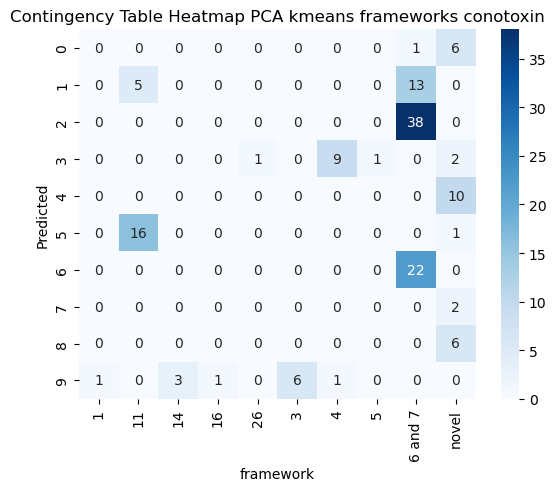

In [95]:
# Create a heatmap using Seaborn
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Blues')
plt.title('Contingency Table Heatmap PCA kmeans frameworks conotoxin')
plt.show()


In [59]:
train_df['Label_specificity_pca'] = predicted

/var/folders/3f/r0wbc5md3fd4qrrzdynqrtzm0000gn/T/ipykernel_54814/3597702289.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Label_specificity_pca'] = predicted


### Don't run

In [34]:
train_df.to_csv('conotoxin_pca_specificity.csv', index=False)

#### UMAP

In [60]:
features= cono_data

In [61]:
features = pd.DataFrame(features, index=train_df['ACC_ID'])
from umap import UMAP
import plotly.express as px



#features = terra_data

umap_2d = UMAP(n_components=2, init='random', random_state=0)
umap_3d = UMAP(n_components=3, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(features)
proj_3d = umap_3d.fit_transform(features)


/Users/arezoobybordi/miniforge3/envs/ninen/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/arezoobybordi/miniforge3/envs/ninen/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


### clusters with 3 clusters

In [62]:
import numpy as np
import pandas as pd
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt


# Perform UMAP dimensionality reduction
umap = UMAP(n_components=3, random_state=42)
umap_embedding = umap.fit_transform(cono_data)

# Perform K-means clustering with the current number of clusters
kmeans = KMeans(n_clusters=10, random_state=42)
labels = kmeans.fit_predict(umap_embedding)

/Users/arezoobybordi/miniforge3/envs/ninen/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [63]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Create a DataFrame with the data
df = pd.DataFrame({'Predicted': labels, 'framework': frameworks})
# Create a contingency table
contingency_table = pd.crosstab(df['Predicted'], df['framework'])

In [64]:
# Display the contingency table
print("Contingency Table:")
print(contingency_table)

Contingency Table:
framework  1  11  14  16  26  3  4  5  6 and 7  novel
Predicted                                            
0          0   0   0   0   0  0  0  0        0      6
1          0   5   0   0   0  0  0  0        2      0
2          0   0   0   0   0  0  0  0       26      0
3          1   0   2   1   0  6  1  0        0      0
4          0   0   0   0   0  0  0  0       29      0
5          0   0   0   0   1  0  9  1        1      2
6          0   0   0   0   0  0  0  0        0     16
7          0   0   0   0   0  0  0  0        7      0
8          0   0   0   0   0  0  0  0        9      1
9          0  16   1   0   0  0  0  0        0      2


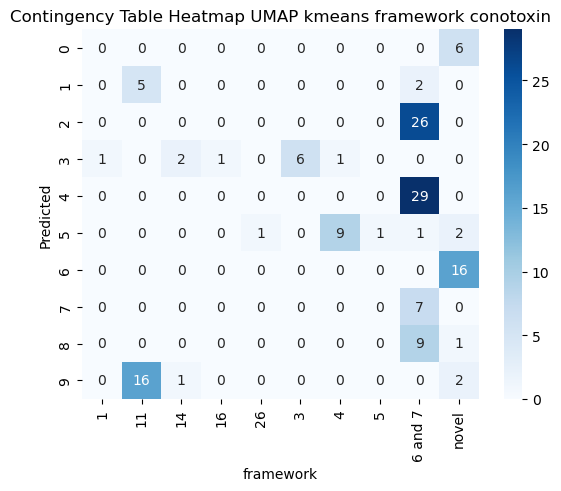

In [66]:
# Create a heatmap using Seaborn
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Blues')
plt.title('Contingency Table Heatmap UMAP kmeans framework conotoxin')
plt.show()


In [46]:
train_df['Label_specificities_umap'] = labels

In [48]:
train_df.to_csv('conotoxin_pca_umap_specificity.csv', index=False)